# W207 Final Project Notebook

In [1]:
#Well be using surprise package heavily as it features packages specifically for recommender systems
!pip install scikit-surprise

In [2]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

from IPython.display import display

from matplotlib.ticker import MultipleLocator

from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from datetime import datetime

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

### Part 1: Load Dataset

In [3]:
%pwd

'/Users/jericojohns/Desktop/W207/W207_movies'

In [4]:
#Load data into ratings_df. 
ratings_df = pd.read_csv("/Users/jericojohns/Desktop/W207/data/ratings_small.csv", low_memory=False)

### Part 2: EDA

In [5]:
#Check structure. 
print(ratings_df.head())

#Check length. 
print(ratings_df.shape)

   userId  movieId  rating   timestamp
0       1       31     2.5  1260759144
1       1     1029     3.0  1260759179
2       1     1061     3.0  1260759182
3       1     1129     2.0  1260759185
4       1     1172     4.0  1260759205
(100004, 4)


In [6]:
#Let's convert the timestamp to a more intuitive datetime
ratings_df['datetime'] = pd.to_datetime(ratings_df['timestamp'], infer_datetime_format = True, yearfirst = True, unit = 's')

#And check our new dataframe
ratings_df

,userId,movieId,rating,timestamp,datetime
0,1,31,2.5,1260759144,2009-12-14 02:52:24
1,1,1029,3.0,1260759179,2009-12-14 02:52:59
2,1,1061,3.0,1260759182,2009-12-14 02:53:02
3,1,1129,2.0,1260759185,2009-12-14 02:53:05
4,1,1172,4.0,1260759205,2009-12-14 02:53:25
...,...,...,...,...,...
99999,671,6268,2.5,1065579370,2003-10-08 02:16:10
100000,671,6269,4.0,1065149201,2003-10-03 02:46:41
100001,671,6365,4.0,1070940363,2003-12-09 03:26:03
100002,671,6385,2.5,1070979663,2003-12-09 14:21:03


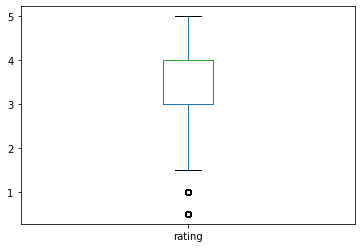

In [7]:
ratings_df[['rating']].plot.box()

Ratings per User:


,rating
userId,
1,20
498,20
448,20
445,20
444,20
...,...
73,1610
15,1700
624,1735


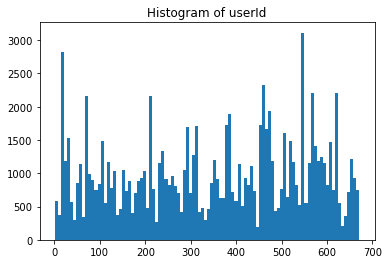

Ratings per Movie


,rating
movieId,
163949,1
26485,1
26480,1
26471,1
26467,1
...,...
260,291
593,304
318,311


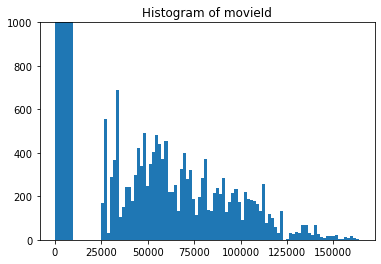

In [8]:
#Check number of ratings per user
print("Ratings per User:")
display(ratings_df[['userId','rating']].groupby('userId').count().sort_values(by = 'rating', ascending = True))


#Show histogram of number of ratings per user
plt.hist(ratings_df['userId'], bins = 100)
plt.title("Histogram of userId")
plt.show()

#Check number of ratings per movie
print("Ratings per Movie")
display(ratings_df[['movieId','rating']].groupby('movieId').count().sort_values(by = 'rating', ascending = True))

#Show histogram of number of ratings per movie
plt.hist(ratings_df['movieId'], bins = 100)
plt.ylim(0,1000)
plt.title("Histogram of movieId")
plt.show()

In [9]:
# Check how many users have 2 or more ratings
display(ratings_df[['userId','rating']].groupby('userId').count().sort_values(by = 'rating', ascending = True))

,rating
userId,
1,20
498,20
448,20
445,20
444,20
...,...
73,1610
15,1700
624,1735


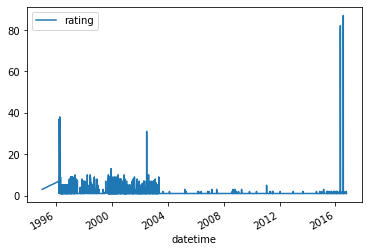

In [10]:
ratings_by_date = ratings_df[['datetime','rating']].groupby('datetime').count().sort_values(by = 'rating', ascending = True)

ratings_by_date.plot()

### Part 3: Baseline Collaborative Filtering Model

In [11]:
#Install recmetrics library for calculating diversity metrics 
#Source: https://github.com/statisticianinstilettos/recmetrics
!pip install recmetrics

In [137]:
#Load surprise packages which is a modified sklearn for recommender systems. 
from surprise import Reader
from surprise import SVD
from surprise import KNNBasic
from surprise import Dataset
from surprise import Trainset
from surprise import accuracy
from surprise.model_selection import LeaveOneOut
from sklearn.preprocessing import MinMaxScaler

from itertools import combinations

#Load recmetrics package
#import recmetrics.metrics

time: 829 µs (started: 2021-07-22 19:13:22 -06:00)


In [13]:
def filter_users(df, min_ratings):
    
    '''Filter users with num_ratings below [min_ratings]
    and sort data by userID and timestamp
    params: df, min_ratings
    return: sorted_filtered_array
    '''
    
    # convert pd.DataFrame in a np.Array
    array = np.array(df)
    # count number of ratings per userID
    userID, num_ratings = np.unique(array[:,0], return_counts=True)
    ratings_per_user = np.asarray((userID, num_ratings)).T
    # filter userIDs with num_ratings >= min_ratings
    users_to_include = ratings_per_user[ratings_per_user[:,1] >= min_ratings][:,0]
    filtered_array = array[np.isin(array[:,0], users_to_include)]
    # sort np.array by userID as primary key and timestamp as secondary key
    idx = np.lexsort((filtered_array[:,3], filtered_array[:,0]))
    sorted_filtered_array = filtered_array[idx]
    return sorted_filtered_array

In [14]:
def train_dev_test_split(array, dev_size=1, test_size=1):
    
    '''Split user ratings data into train, development and test sets
    holding [test_size] ratings per user for test and [dev_size] ratings
    per user for development, following chronological order (ascending timestamp)
    params: df, min_ratings, dev_size, test_size
    return: train_data, dev_data, test_data for one user
    '''
    
    # get array of unique userIDs
    users = np.unique(array[:,0])
    # get indexes to slice data
    idx_1 = -(dev_size + test_size)
    idx_2 = -(test_size)
    # for each userID assign the last [test_size] ratings to test,
    # the previous [dev_size] ratings to development,
    # and the rest of ratings data to training
    for i, userID in enumerate(users):
        if i == 0:
            train_data = array[array[:,0]==userID][:idx_1,:]
            dev_data = array[array[:,0]==userID][idx_1:idx_2,:]
            test_data = array[array[:,0]==userID][idx_2:,:]
        else:
            train_data = np.vstack((train_data, array[array[:,0]==userID][:idx_1,:]))
            dev_data = np.vstack((dev_data, array[array[:,0]==userID][idx_1:idx_2,:]))
            test_data = np.vstack((test_data, array[array[:,0]==userID][idx_2:,:]))
    # return train_data, dev_data and test_data
    return train_data, dev_data, test_data

In [15]:
def GetTopN(predictions, n=10, minimumRating=0.0):
    '''Get the top n predicted movie ratings for a given user.'''
    topN = defaultdict(list)
    for userID, movieID, actualRating, estimatedRating, _ in predictions:
        if (estimatedRating >= minimumRating):
            topN[int(userID)].append((int(movieID), estimatedRating))

    for userID, ratings in topN.items():
        ratings.sort(key=lambda x: x[1], reverse=True)
        topN[int(userID)] = ratings[:n]

    return topN

In [16]:
def HitRate(topNpredictions,leftoutpredictions):
    '''Take the most recent rating out of the training set to use in our test set, 
    and the second most recent to use in our dev set. If the top-n list of recommendations (predicted ratings)
    for a user contain the dev / test movie, we increase hit ratio by 1
    
    Source: https://medium.com/@rishabhbhatia315/recommendation-system-evaluation-metrics-3f6739288870''' 
    
    hits=0
    total=0
    for leftout in leftoutpredictions:
        userID = leftout[0]
        leftoutmovieId = leftout[1]
        hit = False
        for movieId ,predictedRating in topNpredictions[int(userID)]:
            if(int(movieId)==int(leftoutmovieId)):
                hit = True
        if(hit):
            hits+=1
        total+=1 
    
    return hits/total 

In [17]:
def HitRateAdjusted(topNpredictions,leftoutpredictions):
    '''Take the most recent rating out of the training set to use in our test set, 
    and the second most recent to use in our dev set. If the top-n list of recommendations (predicted ratings)
    for a user contain the dev / test movie, we increase hit ratio by 1 
    OR if the leftout movie is lower rated than the top n list (i.e. we correctly would not recommend to user) increase hit rate by 1.
    
    Source: https://medium.com/@rishabhbhatia315/recommendation-system-evaluation-metrics-3f6739288870''' 
    
    hits=0
    total=0
    for leftout in leftoutpredictions:
        userID = leftout[0]
        leftoutmovieId = leftout[1]
        leftoutrating = leftout[2]
        
        hit = False
        
        topNmovies = []
        topNRatings = []
        
        for movieId ,predictedRating in topNpredictions[int(userID)]:
            topNmovies.append(movieId)
            topNRatings.append(predictedRating)
        
        max_top_N_rating = max(topNRatings)
        min_top_N_rating = min(topNRatings)
        
        if leftoutrating < min_top_N_rating and leftoutmovieId not in topNmovies: 
            hit = True
        elif leftoutrating > min_top_N_rating and leftoutmovieId in topNmovies: 
            hit = True
        else: 
            hit = False
        
        if(hit):
            hits+=1
        total+=1 
    
    return hits/total 

In [18]:
def Diversity(topNPredicted, simsAlgo):
    '''where simsalgo = similarities.cosine() from surprise.'''
    n = 0
    total = 0
    simsMatrix = simsAlgo.compute_similarities()
    for userID in topNPredicted.keys():
        pairs = itertools.combinations(topNPredicted[userID], 2)
        for pair in pairs:
            movie1 = pair[0][0]
            movie2 = pair[1][0]
            innerID1 = simsAlgo.trainset.to_inner_iid(str(movie1))
            innerID2 = simsAlgo.trainset.to_inner_iid(str(movie2))
            similarity = simsMatrix[innerID1][innerID2]
            total += similarity
            n += 1
            
    S = total / n
    return (1-S)

In [19]:
def Novelty(topNPredicted, rankings):
    n = 0
    total = 0
    for userID in topNPredicted.keys():
        for rating in topNPredicted[userID]:
            movieID = rating[0]
            rank = rankings[movieID]
            total += rank
            n += 1
    return total / n

Good image to load in this spot: 
    https://www.google.com/url?sa=i&url=https%3A%2F%2Fstats.stackexchange.com%2Fquestions%2F390629%2Freference-point-in-projection-axis-of-svd-singular-value-decomposition&psig=AOvVaw1Lsj4Ue1mqmrwy-4FUoV7X&ust=1625783276443000&source=images&cd=vfe&ved=0CAoQjRxqFwoTCLDL7_GA0vECFQAAAAAdAAAAABA1   

### Implementation of our SVD Algorithm for Matrix Factorization based Collaborative Filtering: 

#### Train, Val, Test Splits

In [20]:
#Filter our user list to those users who have 30+ ratings
filtered_data = filter_users(ratings_df, min_ratings = 30)

#Now split our data so that we take the n-1 (most recent) rating as our test rating, 
#and n-2 (second most recent) rating as our dev rating 
train_data, dev_data, test_data = train_dev_test_split(filtered_data)

#We no longer need timestamp / datatime data. 
train_data = train_data[:,0:3]
dev_data = dev_data[:,0:3]
test_data = test_data[:,0:3]

#Now we need to convert our train, dev, and test data back to the Suprise Dataset object type to use their SVD algorithm. 
#First we convert each train/dev/test arrays into dataframes
train_df = pd.DataFrame(train_data, index = None, columns = ['userId', 'movieId','rating'])
dev_df = pd.DataFrame(dev_data, index = None, columns = ['userId', 'movieId','rating'])
test_df = pd.DataFrame(test_data, index = None, columns = ['userId', 'movieId','rating'])

#Create a surprise Reader object to help us create a Surprise DataSet object. 
reader = Reader()

#Now we load training data as is (no folding) by calling the .build_full_trainset() method. 
train_data = Dataset.load_from_df(train_df, reader).build_full_trainset()

#Convert dev_data and test_data to DataSet objects, and then as testset objects by calling .buildtestset()
dev_data = Dataset.load_from_df(dev_df, reader).build_full_trainset()
dev_data = dev_data.build_testset()

test_data = Dataset.load_from_df(test_df, reader).build_full_trainset()
test_data = test_data.build_testset()

#### Train and Test Baseline Model

In [151]:
#Train and test algorithm (Matrix Factorization for Collaborative Filtering)
algo = SVD()

#Train our train_data (all user's that have liked 30+ movies, train on the n-2 movie set)
algo.fit(train_data)

#Predict rating for the 1 dev movie
leftoutpredictions = algo.test(dev_data)

#Now predict ratings for all movies that are not in the trainingset
largeTestSet = train_data.build_anti_testset()
allPredictions = algo.test(largeTestSet)

#Set our n value for how how many top predicted movies we'll test against
n = 10

#Compute top 10 recs for each user using our defined topNPredicted Function above
topNPredicted = GetTopN(allPredictions, n=n)

#Calculate our evaluation metrics of interest
hit_rate = HitRate(topNPredicted, leftoutpredictions)
adjusted_hit_rate = HitRateAdjusted(topNPredicted, leftoutpredictions)
rmse = accuracy.rmse(leftoutpredictions, verbose = False)

#Print our evaluation metrics of interest
print(f'Hit Rate for n = {n}: {hit_rate:.3f}')
print(f'Adjusted Hit Rate for n = {n}: {adjusted_hit_rate:.3f}')
print(f'Root Mean Squared Error: {rmse:.3f}')

Hit Rate for n = 10: 0.018
Adjusted Hit Rate for n = 10: 0.736
Root Mean Squared Error: 0.940
time: 37 s (started: 2021-07-22 19:41:22 -06:00)


#### Diversity Metric Calculations

In [71]:
#Try calculating some diversity metrics from recmetrics

#1.) Novelty
rankings = ratings_df["movieId"].value_counts()

novelty = Novelty(topNPredicted, rankings)

print(f'Novelty for n = {n}: {novelty:.3f}')

#2.) Diversity (WIP)
#c = {'name':'cosine', 'user_based': True}

#simsAlgo = KNNBasic(sim_options = c)

# diversity = Diversity(topNPredicted, simsAlgo = algo)

Novelty for n = 100: 79.830
time: 152 ms (started: 2021-07-22 16:57:48 -06:00)


In [146]:
#Let's standardize our rankings to be able to be used together 
scaler = MinMaxScaler(feature_range = (0,5))
ranking_movieID = rankings.index.to_numpy()

sc_rankings = rankings.to_numpy().reshape(-1,1)
sc_rankings = scaler.fit_transform(sc_rankings)

sc_rankings = sc_rankings.tolist()

#TODO: Check that this adjustment makes sense and keeps ranking meaning 
#Since ranking is actually just a movieID count in the dataset, we need to inverse the value
#by multiplying by -1, and then renormalize to 0,5 scale by adding 5. So that least popular movies
#have rating close to 5 and most popular movies have ratings close to 0. 
sc_rankings = [(float(i[0])*-1)+5 for i in sc_rankings]

ranking_movieID = ranking_movieID.tolist()

time: 6.07 ms (started: 2021-07-22 19:20:07 -06:00)


#### Add Diversity Into Optimization Problem (Modified Cost Function)

In [147]:
#Pull top-10 predicted ratings + rankings. This is our new ordered list. 
def GetTopNAdjusted(predictions, ranking_list, ranking_movies, n=10, minimumRating=0.0, w1 = 0.5, w2 = 0.5):
    '''Get the top n predicted movie ratings for a given user.'''
    topN = defaultdict(list)
    remainingN = defaultdict(list)
    
    for userID, movieID, actualRating, estimatedRating, _ in predictions:
        if (estimatedRating >= minimumRating):
            
            #Adjustment to solve for novelty within equation
            noveltyRanking = ranking_list[ranking_movies.index(movieID)]
            
            estBlendedRating = (w1 * estimatedRating) + (w2 * noveltyRanking)
            
            topN[int(userID)].append((int(movieID), estBlendedRating))
            
    for userID, ratings in topN.items():
        ratings.sort(key=lambda x: x[1], reverse=True)
        topN[int(userID)] = ratings[:n]
        #Pull the next n items as the remainingN list 
        remainingN[int(userID)] = ratings[n:(n+n)]

    return topN, remainingN

time: 1.73 ms (started: 2021-07-22 19:20:09 -06:00)


In [161]:
#Note: w1 = weight * rating, w2 = weight * ranking (novelty)
topNPredicted_Blended, remainingNPredicted = GetTopNAdjusted(allPredictions, sc_rankings, ranking_movieID, n=10, w1 = 0.9, w2 = 0.1)

time: 4min 22s (started: 2021-07-22 20:09:48 -06:00)


In [162]:
#COMPARE BLENDED VS NON-BLENDED 

#Compute top 10 recs for each user using our defined topNPredicted Function above
topNPredicted = GetTopN(allPredictions, n=10)

#Calculate our evaluation metrics of interest
hit_rate = HitRate(topNPredicted, leftoutpredictions)
hit_rate_Blended = HitRate(topNPredicted_Blended, leftoutpredictions)
adjusted_hit_rate = HitRateAdjusted(topNPredicted, leftoutpredictions)
adjusted_hit_rate_Blended = HitRateAdjusted(topNPredicted_Blended, leftoutpredictions)
#rmse = accuracy.rmse(leftoutpredictions, verbose = False)
#Print our evaluation metrics of interest
print(f'Hit Rate for n = {n}: {hit_rate:.3f}')
print(f'Blended Hit Rate for n = {n}: {hit_rate_Blended:.3f}')
print(f'Adjusted Hit Rate for n = {n}: {adjusted_hit_rate:.3f}')
print(f'Blended, Adjusted Hit Rate for n = {n}: {adjusted_hit_rate_Blended:.3f}')

Hit Rate for n = 10: 0.018
Blended Hit Rate for n = 10: 0.002
Adjusted Hit Rate for n = 10: 0.736
Blended, Adjusted Hit Rate for n = 10: 0.758
time: 3.72 s (started: 2021-07-22 20:14:56 -06:00)


In [ ]:
#Create list of user's movieID's, movie rankings (for novelty), and movie estimated rating 
%load_ext autotime

w1 = 0.5 
w2 = 1 - w1 

blendedtopN = defaultdict(list)

best_combo = ()

for userID in list(topNPredicted.keys())[:1]:
    user_list = [] 
    movie_list = []
    rank_list = []
    rating_list = [] 
    
    best_score = 0 
    
    for rating in topNPredicted[userID]: 
        user_list.append(userID)
        movie_list.append(rating[0])
        rank_list.append(rankings[rating[0]])
        rating_list.append(rating[1])
    
    
    
    for combo in combinations(movie_list, 10): 
        #Initialize running sums to zero
        rating_sum = 0 
        novelty_sum = 0
        
        for movie in combo: 
            idx = movie_list.index(movie)
            rating_sum += rating_list[idx]
            novelty_sum += rank_list[idx]
            
        blended_score = (w1*rating_sum) + (w2*novelty_sum)
        
        if blended_score > best_score: 
            best_combo = combo 
            best_score = blended_score
        
    print(f'User ID: {userID}, Best Combo: {best_combo}, Best Score: {best_score}')
            
            
            
            
# print(user_list)
# print(movie_list)
# print(rank_list)
# print(rating_list)

We are pulling the SVD initialization (below) from Surprise code directly to create our modified SVD class: 
https://github.com/NicolasHug/Surprise/blob/master/surprise/prediction_algorithms/matrix_factorization.pyx

In [ ]:
#NOT USED

#https://realpython.com/python-scipy-cluster-optimize/#using-the-optimize-module-in-scipy

#Pull top 100 predicted movies, then select top 10 movie rating + novelty from this constrained list
def objective_function(topNPredicted, rankings): 
    for userID in topNPredicted.keys(): 
        for rating in topNPredicted[userID]: 
            movieID = rating[0]
            est_rating = rating[1]
            rank = rankings[movieID]
            
            
            
            
    
    
    

Notes: 
- Might help to break out the adjusted hit rate by the positive hit rate and negative hit rate (in list, vs lower ranked than top n list and not in list, vs higher ranked than top n list and not in list). 
